## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [253]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [254]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [255]:
df.shape[0]

294478

- There are 294478 rows in the dataset.

c. The number of unique users in the dataset.

In [256]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [257]:
round(df['converted'].mean(),4)

0.1197

e. The number of times the `new_page` and `treatment` don't match.

In [258]:
df.query("group == 'treatment' and landing_page != 'new_page' or group != 'treatment' and landing_page =='new_page'")['user_id'].count()

3893

f. Do any of the rows have missing values?

In [259]:
df.isnull().sum().any()

False

- There are no missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset that meets the specifications and store your new dataframe in **df2**.

- I will make a query for the mismatch between group column and landing_page column and drop these valuse to make sure treatment match with new_page and control match with old_page.

In [260]:
df2 = df.drop(df.query('group == "treatment" and landing_page != "new_page" or group != "treatment" and landing_page == "new_page" or group == "old_page" and landing_page != "control" or group != "old_page" and landing_page == "control"').index)

In [261]:
df2.query('group == "treatment" and landing_page != "new_page" or group != "treatment" and landing_page == "new_page" or group == "old_page" and landing_page != "control" or group != "old_page" and landing_page == "control"')['user_id'].count()

0

In [262]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions.

a. How many unique **user_id**s are in **df2**?

In [263]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [264]:
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [265]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [266]:
df2 = df2.drop(df2[(df2.user_id == 773192) & (df2['timestamp'] == '2017-01-09 05:37:58.781806')].index)

In [267]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


- The duplicated user_id is removed.

`4.` Use **df2** in the cells below to answer the questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [162]:
conv_users = df2.query('converted == 1')['user_id'].count()
total_users = df2.shape[0]
p1 = conv_users / total_users
round(p1, 4)

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [163]:
cont_conv_users = df2.query('converted == 1 and group == "control"')['user_id'].count()
cont_users = df2.query('group == "control"')['user_id'].count()
p2 = cont_conv_users / cont_users
round(p2, 4)

0.12039999999999999

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [164]:
conv_treat_users = df2.query('converted == 1 and group == "treatment"')['user_id'].count()
treat_users = df2.query('group == "treatment"')['user_id'].count()
p3 = conv_treat_users / treat_users
round(p3, 4)

0.1188

d. What is the probability that an individual received the new page?

In [165]:
new_users = df2.query('landing_page == "new_page"')['user_id'].count()
total_users = df2.shape[0]
p4 = new_users / total_users
round(p4, 4)

0.50009999999999999

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Actually No, there is no sufficient evidence to conclude that the new treatment page leads to more conversions because the conversion rate in the treatment group which is 0.1188 is decreased compared to the conversion rate in the control group that is 0.1204 .**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis and alternative hypothesis:

$$H_{0}: p_{new} - p_{old} ≤ 0$$

$$H_{1}: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [166]:
p_new = round(df2[df2['converted'] == 1].count() / df2.shape[0],4)['user_id']
p_new

0.1196

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [167]:
p_old = round(df2[df2['converted'] == 1].count() / df2.shape[0],4)['user_id']
p_old

0.1196

In [168]:
p_new - p_old

0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [169]:
n_new = df2[df2['group'] == "treatment"].nunique()['user_id']
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [170]:
n_old = df2[df2['group'] == "control"].nunique()['user_id']
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [235]:
new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
new_page_converted

array([1, 0, 0, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [241]:
old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
old_page_converted

array([0, 1, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [242]:
obse_diff = new_page_converted.mean() - old_page_converted.mean()
obse_diff

-0.0016774386688173104

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [243]:
p_diffs = []
for x in range(10000):
    bootsample = df2.sample(df2.shape[0], replace=True)
    new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
    old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
    new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'The distribution of p_diffs')

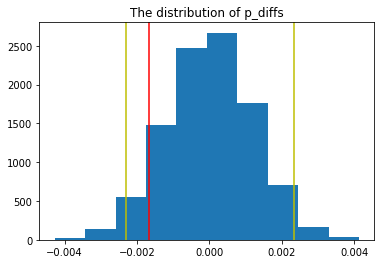

In [244]:
p_diffs = np.array(p_diffs)

lower = np.percentile(p_diffs, 2.5)
upper = np.percentile(p_diffs, 97.5)

plt.hist(p_diffs);
plt.axvline(x=obse_diff, color='r')
plt.axvline(x=lower, color='y')
plt.axvline(x=upper, color='y')
plt.title('The distribution of p_diffs')

Yes, as I expected according to the central limit theorom with a large sample size it looks normally distributed and most of the data falls within the 95% confidence interval.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [245]:
conv_treat_p = df2.query('group == "treatment"')['converted'].mean()
conv_cont_p = df2.query('group == "control"')['converted'].mean()
actual_diff_obs = conv_treat_p - conv_cont_p
actual_diff_obs

-0.0015782389853555567

In [246]:
print('The proportion of the "p_diffs" are greater than the "actual difference observed" is:',(p_diffs > actual_diff_obs).mean())

The proportion of the "p_diffs" are greater than the "actual difference observed" is: 0.9069


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I've just computed what is called (p_value) that equals to alpha=0.05 and indicates with a value greater than 0.05 the null hypothesis is true and with a values less than or equal to 0.05 we reject the null hypothesis and accept the alternative hypothesis, since the observed difference between p_new and p_old is -0.00158 this means the old page has a better conversion rate and since the p_value > 0.05 so we fail to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [247]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1')['user_id'].nunique()
convert_new = df2.query('group == "treatment" and converted == 1')['user_id'].nunique()
n_old = df2.query('group == "control"')['user_id'].nunique()
n_new = df2.query('group == "treatment"')['user_id'].nunique()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [248]:
import statsmodels.api as sm
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='smaller')
z_score, p_value


(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z_score measures the standard deviation of a raw score from the mean and in our case here it equals to 1.3109 and located between the critical values -1.96 and 1.96, and the p_value is still greater than alpha=0.05, so z_score and p_value support our findings we fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I'm going to use the logistic regression since the variables are categorical not numerical.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [268]:
import statsmodels.api as sm
df2['intercept'] = 1

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [269]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-17 14:59 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**p_value associated with ab_page is 0.1899 and it is still larger than alpha = 0.05, that means the landing_page is not statistically significant to predict the conversion rate.
The null and alternative hypothesis are like that:**
$$H_{0}: p_{new} = p_{old} $$

$$H_{1}: p_{new}  != p_{old} $$

**the p_value is different here than in part II because the null and alternative hypothesis were like that to predict which page has more conversion:**
$$H_{0}: p_{new} - p_{old} ≤ 0$$

$$H_{1}: p_{new} - p_{old} > 0$$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Since we cannot predict the conversion rate based on the landing_page it is a good idea to consider another factor that may affect whether or not an individual converts. sometimes this practice has disadvantages if two variables are highly related to each other.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [270]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [272]:
df2 = df2.set_index('user_id').join(df_countries.set_index('user_id'), how='inner')
df2.head()


,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [273]:
country_dummies = pd.get_dummies(df2['country'])
df2 = df2.join(country_dummies)
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [277]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK', 'US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-17 15:06 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**Looking at the regression model it is obvious that the p_value is greater than alpha=0.05 that means the country is not statistically significant to predict the conversion rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [278]:
df2['US_page'] = df2['US'] * df2['ab_page']
df2['UK_page'] = df2['UK'] * df2['ab_page']

In [279]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'US_page', 'UK_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-17 15:09 AIC:              212781.7674
No. Observations:   290584           BIC:              212813.5064
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
US_page      -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
UK_page       0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
==================================================================

"""

## Conclusion:

When we take a look on the p_value after calculating the interaction between country and page it seems obviously greater than alpha or type 1 error = 0.05, which means that even though when adding addithional factor and the interaction the results are not statistically significant to predict wether or not the individual convert with the new page. At last after we calculate the propability, hypothesis test and the regresion model we have no evidence to reject the null hypothesis, so we fail to reject the null hypothesis. 